In [73]:
import pandas as pd
import numpy as np
import os


data_dir = os.path.join(os.getcwd(), 'data', 'files')

def _make_path(subd, fname):
    return os.path.join(subd, fname)

tval = pd.read_csv(_make_path(data_dir, 'train_values.csv'), index_col='sequence_id')
tlab = pd.read_csv(_make_path(data_dir, 'train_labels.csv'), index_col='sequence_id')

len(tval), len(tlab)

(63017, 63017)

### Base Scores

**Logistic Reg**: 0.39
**Random Forest**: 0.427

## Sequence Length

Count number of bp in each sequence.

In [67]:
tval['seq_length'] = tval.sequence.str.len()
tval.seq_length.describe()

count    63017.000000
mean      4839.025501
std       3883.148431
min         20.000000
25%        909.000000
50%       4741.000000
75%       7490.000000
max      60099.000000
Name: seq_length, dtype: float64

In [68]:
# Save
tval.to_csv(_make_path(data_dir, 'train_values_mod.csv'))

### Results

**Random Forest**: 0.565

Improvement of 13% (no tuning)

## GC Concentration

Proxy for binding affinity in the cell.  Could differ between engineering techniques.

In [74]:
import Bio
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import GC

import numpy as np

gc = []

# Calculate GC content for each sequence
for i in range(len(tval)):
    seq = tval.iloc[i].sequence
    gc.append(GC(seq))
    
tval['gc'] = gc

In [75]:
# Scale data

from sklearn.preprocessing import RobustScaler

rsdata = tval['gc'].to_numpy().reshape(-1,1)

t = RobustScaler().fit(X=rsdata)
tval['gc'] = t.transform(rsdata).reshape(1,-1)[0]

<AxesSubplot:ylabel='Density'>

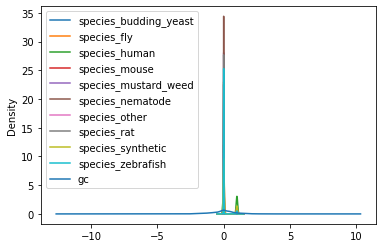

In [71]:
# View Data
keep = [col for col in tval.columns if 'species' in col]
keep.append('gc')

tval[keep].plot.kde()

In [76]:
# Save
tval.to_csv(_make_path(data_dir, 'train_values_mod.csv'))

### Results

**Random Forest**: 0.478

Improvement of 5% no tuning.


#### Combination with:

>GC Concentration- **Random Forest**: 0.641



## Coding vs Noncoding

Identifying coding region vs non-coding region.  The relationship between the two could yield insights into programmed regulatory complexity and may be a signature for lab maturity, excellence, ability.

In [18]:
import Bio
from Bio import SeqIO
import os

data_dir = os.path.join(os.getcwd(), 'data', 'files')

species_dirs = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if 'species' in d]
species = ['_'.join(d.split('_')[1:]) for d in species_dirs]

def _get_seqs(sdir):
    return [
        os.path.join(sdir, f) for f in os.listdir(sdir) if '.txt' in f
    ]

seqs = _get_seqs(species_dirs[0])

Bio.__version__

'1.78'

In [23]:
from Bio.SeqUtils import GC

for s in SeqIO.parse(seqs[0], 'fasta'):
    print(s.id)  # FASTA ID (sequence index from origin)
#     print(s.seq)
    print(len(s))  # Sequence Length
    print(GC(s.seq)) #
    

03SLJ
5154
46.00310438494373


### Considerations

1. Biopython just needs a 'fasta' like file and can probably be adapted to read from a string io buffer.  This is much easier to pipeline.

2.  Lots of cool features!!